# Analisis Eksplorasi Data & Pemodelan Machine Learning
## Proyek: AgriSmart - Crop Recommendation System

Notebook ini mendokumentasikan proses *end-to-end* pengembangan model, mulai dari eksplorasi data, preprocessing dengan simulasi noise, pelatihan model (Naive Bayes vs XGBoost), hingga evaluasi mendalam menggunakan SHAP Values.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

### 1. Load Dataset & Review Awal
Dataset yang digunakan adalah *Crop Recommendation Dataset* yang terdiri dari 2.200 baris data dengan 22 kelas tanaman yang seimbang.

In [2]:
try:
    df = pd.read_csv('Crop_recommendation.csv')
    print(f"Dimensi Dataset: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print("⚠️ Dataset tidak ditemukan!")

Dimensi Dataset: (2200, 8)


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


### 2. Preprocessing & Strategi Robustness (Noise Injection)
Untuk mensimulasikan kondisi sensor lapangan yang tidak selalu akurat, kami menyuntikkan **Gaussian Noise (15%)** ke dalam data latih. Ini bertujuan untuk menguji dan meningkatkan ketahanan (*robustness*) model.

In [3]:
def add_noise(df, noise_level=0.05):
    """Menambahkan noise random ke fitur numerik"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_noisy = df.copy()
    for col in numeric_cols:
        noise = np.random.normal(0, noise_level * df[col].std(), len(df))
        df_noisy[col] = df[col] + noise
    return df_noisy

# Implementasi Noise 15%
df_noisy = add_noise(df, noise_level=0.15)
print("✅ Gaussian Noise 15% berhasil ditambahkan.")

X = df_noisy.drop('label', axis=1)
y = df_noisy['label']
feature_names = X.columns.tolist()

# Split Data 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi (MinMax Scaling)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

✅ Gaussian Noise 15% berhasil ditambahkan.


### 3. Pemodelan (Baseline vs Advanced)
Kami membandingkan **Naive Bayes** (Baseline) dengan **XGBoost** (Proposed) untuk melihat efektivitas boosting dalam menangani data ber-noise.

In [ ]:
# Encode Label Target
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- Model 1: Naive Bayes (Baseline) ---
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)
y_pred_nb = nb_model.predict(X_test_scaled)
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"📊 Akurasi Baseline (Naive Bayes): {acc_nb*100:.2f}%")

# --- Model 2: XGBoost (Proposed) ---
xgb_model = xgb.XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=5, 
    random_state=42, use_label_encoder=False, eval_metric='mlogloss'
)
xgb_model.fit(X_train_scaled, y_train_enc)
y_pred_xgb = xgb_model.predict(X_test_scaled)
acc_xgb = accuracy_score(y_test_enc, y_pred_xgb)
print(f"🚀 Akurasi XGBoost: {acc_xgb*100:.2f}%")

### 4. Evaluasi Kinerja (Akurasi & F1-Score)
Evaluasi mendalam menggunakan Confusion Matrix dan F1-Score untuk memastikan keseimbangan presisi dan recall.

🏆 XGBoost Final Accuracy: 94.32%
⚖️  XGBoost F1-Score (Macro): 93.98%


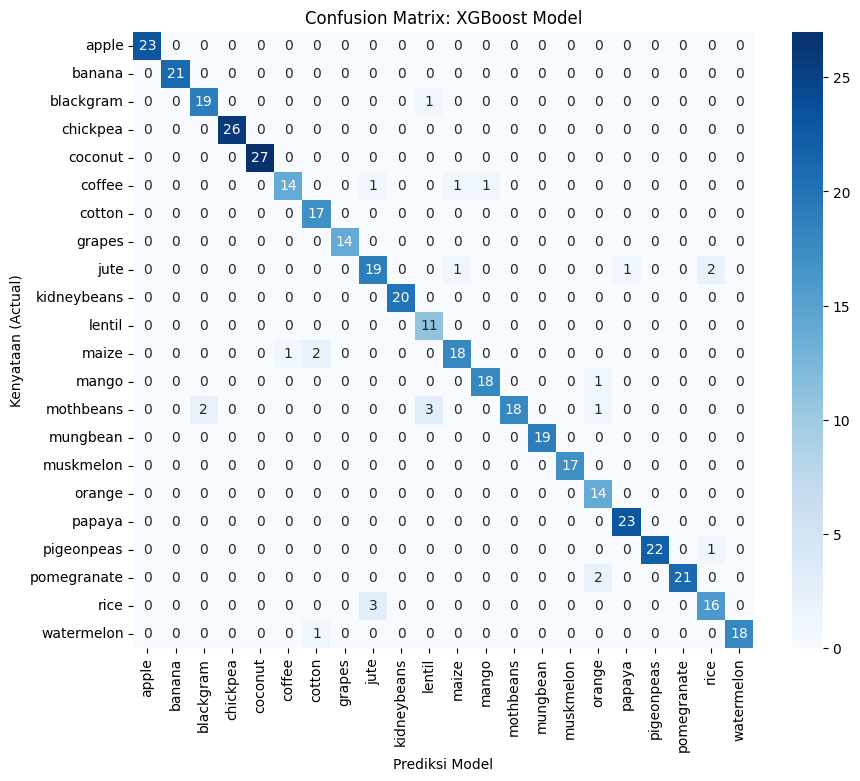

In [5]:
y_pred_label = le.inverse_transform(y_pred_xgb)

# Hitung F1 Score Macro
f1 = f1_score(y_test, y_pred_label, average='macro')
print(f"🏆 XGBoost Final Accuracy: {acc_xgb*100:.2f}%")
print(f"⚖️  XGBoost F1-Score (Macro): {f1*100:.2f}%")

# Visualisasi Confusion Matrix
cm = confusion_matrix(y_test, y_pred_label)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix: XGBoost Model')
plt.ylabel('Kenyataan (Actual)')
plt.xlabel('Prediksi Model')
plt.xticks(rotation=90)
plt.show()

### 5. Explainable AI (SHAP Analysis)
Menggunakan SHAP Values untuk mengetahui fitur mana yang paling dominan dalam menentukan jenis tanaman.

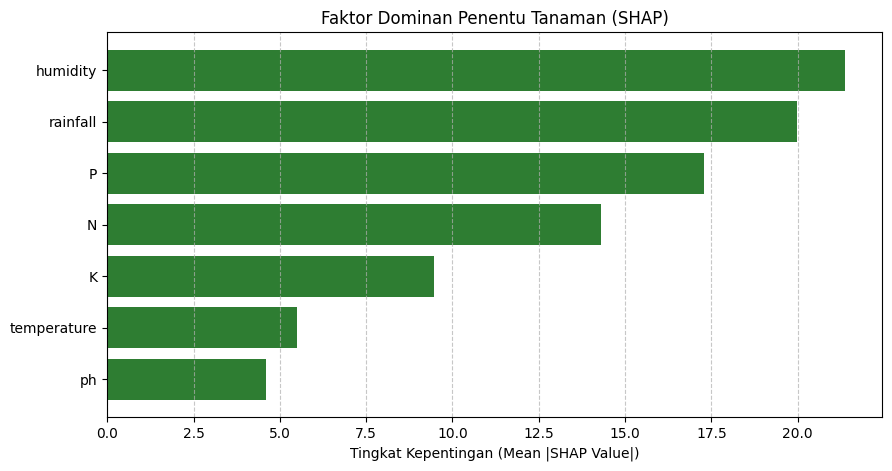

In [6]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_scaled)

# Kalkulasi Rata-rata SHAP Value (Global Importance)
vals = np.abs(shap_values.values).mean(0)
if len(vals.shape) > 1:
    vals = vals.sum(1)

# Plotting Grafik Batang Hijau (Clean Style)
feature_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['Fitur', 'Importance'])
feature_importance.sort_values(by=['Importance'], ascending=True, inplace=True)

plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Fitur'], feature_importance['Importance'], color='#2E7D32')
plt.xlabel("Tingkat Kepentingan (Mean |SHAP Value|)")
plt.title("Faktor Dominan Penentu Tanaman (SHAP)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()